In [1]:
using MHDFlows
using PyPlot
using CUDA,Statistics
using LinearAlgebra: mul!, ldiv!

┌ Info: FourierFlows will use 4 threads
└ @ FourierFlows /home/doraho/.julia/packages/FourierFlows/DtzuG/src/FourierFlows.jl:123


In [2]:
#device!(1)
#device()

## Forcing Module Scheme from Cho
From Cho,

$$ f_k = A e^{vk^2_fdt} e^{i(\phi_1+\phi_2)/2}[{\bf s_1} cos(\frac{\phi_2-\phi_1}{2})+ {\bf s_2}sin \frac{\phi_2 - \phi_1 }{2}]$$

In [4]:
function ChoFroceScheme2!(N_, sol, t, clock, vars, params, grid)
  str = string
  T   = eltype(vars.nonlinh1)
  f_ih = zeros(T,size(vars.nonlinh1));

  Φ1T,Φ2T,AT = vars.Φ1,vars.Φ2,vars.A;
  fox,foy,foz = params.fo[1,:],params.fo[2,:],params.fo[3,:];
  s1,s2 = params.s1,params.s2;  
  dt  = clock.dt;  
  Random_iterator!(Φ1T,Φ2T,AT);  
  v = -0;
  Offset = div(size(vars.ux)[1],2);  
  k_conponment = length(Φ1T);
    
  #Create A,Φ2 to CPU if GPU is enable
  A  = Array{T}(AT);  
  Φ1 = Array{T}(Φ1T); 
  Φ2 = Array{T}(Φ2T);
  #println("N,",sum(N_))    
  for (u_ind,i) ∈ zip([params.ux_ind,params.uy_ind,params.uz_ind],[1,2,3])
      @. f_ih*=0;  
      for k_i = 1:k_conponment
        k_fx,k_fy,k_fz = fox[k_i]+1,foy[k_i]+Offset,foz[k_i]+Offset;
        kf2 = k_fx^2+k_fy^2+k_fz^2; 
        f_ih[k_fx,k_fy,k_fz]  = A[1]*exp(v*kf2*dt)*exp(im/2*(Φ1[k_i]+Φ2[k_i]))*
                    (s1[i,k_i]*cos((Φ2[k_i]-Φ1[k_i])/2)+s2[i,k_i]*sin((Φ2[k_i]-Φ1[k_i])/2));
      end
      @. vars.nonlinh1*=0;
      copyto!(vars.nonlinh1, f_ih);   
      ldiv!(vars.nonlin1, grid.rfftplan, deepcopy(vars.nonlinh1));  
      mul!(vars.nonlinh1, grid.rfftplan, vars.nonlin1) 

      N_[:,:,:,u_ind] .+= vars.nonlinh1;
      #println("N,",sum(N_[:,:,:,u_ind]))   
  end
  #N.=N; 
end
function Random_iterator!(Φ1,Φ2,A)
    #random generator ∈ [-1,1]
    rand1CPU(n::Int;T=Float32) = 2.0 .*(rand(T,n).-0.5);
    rand1CUDA(n::Int;T=Float32) = 2.0 .*(CUDA.rand(T,n).-0.5);
    
    rand1 = Φ1 isa CuArray ? rand1CUDA : rand1CPU;
    T = eltype(Φ2)
    k_conponment = length(Φ1);
    Φ_changefraction   = convert(T,0.02);
    A_changefraction   = convert(T,0.01);

    # For each time step, slowly changing the amplitude or phase by 1 or 2%
    Φ1 .= Φ1.*( 1 .+ 2*π .*rand1(k_conponment;T=T).*Φ_changefraction);
    Φ2 .= Φ2.*( 1 .+ 2*π .*rand1(k_conponment;T=T).*Φ_changefraction);
    #just 1 conponment for now
    A .= A.*(1.0 .+ rand1(1;T=T)*A_changefraction);
end    

Random_iterator! (generic function with 1 method)

In [5]:
function ProblemGeneratorTG!(prob;L0=2π,N=length(prob.grid.x))

  # Output Setting  
  xx,yy,zz = fill(0.0,N,N,N),fill(0.0,N,N,N),fill(0.0,N,N,N);
  
  l = 2*π/L0;    
  for k ∈ 1:N, j ∈ 1:N, i ∈ 1:N
    xx[i,j,k] = l*prob.grid.x[i];
    yy[i,j,k] = l*prob.grid.y[j];
    zz[i,j,k] = l*prob.grid.z[k];
  end
    
  pfactor = 4/3*sqrt(2/3);
  R  = 0;
    

  ux = @. cos(yy);
  uy = @. 0*cos(yy);
  uz = @. 0*cos(yy);

  bx = @. sqrt(1e-3)*ux;
  by = @. sqrt(1e-3)*uy;
  bz = @. sqrt(1e-3)*uz;       
    
  copyto!(prob.vars.ux, ux);
  copyto!(prob.vars.uy, uy);
  copyto!(prob.vars.uz, uz);
  copyto!(prob.vars.bx, bx);
  copyto!(prob.vars.by, by);
  copyto!(prob.vars.bz, bz);

  #Update V + B Fourier Conponment
  uxh = prob.sol[:, :, :, prob.params.ux_ind];
  uyh = prob.sol[:, :, :, prob.params.uy_ind];
  uzh = prob.sol[:, :, :, prob.params.uz_ind];
    
  bxh = prob.sol[:, :, :, prob.params.bx_ind];
  byh = prob.sol[:, :, :, prob.params.by_ind];
  bzh = prob.sol[:, :, :, prob.params.bz_ind];

  mul!(uxh, prob.grid.rfftplan, prob.vars.ux);   
  mul!(uyh, prob.grid.rfftplan, prob.vars.uy);
  mul!(uzh, prob.grid.rfftplan, prob.vars.uz);
  mul!(bxh, prob.grid.rfftplan, prob.vars.bx);
  mul!(byh, prob.grid.rfftplan, prob.vars.by);
  mul!(bzh, prob.grid.rfftplan, prob.vars.bz);
    
  prob.sol[:, :, :, prob.params.ux_ind] .= uxh;
  prob.sol[:, :, :, prob.params.uy_ind] .= uyh;
  prob.sol[:, :, :, prob.params.uz_ind] .= uzh;
  prob.sol[:, :, :, prob.params.bx_ind] .= bxh;
  prob.sol[:, :, :, prob.params.by_ind] .= byh;
  prob.sol[:, :, :, prob.params.bz_ind] .= bzh;
    
  MHDupdatevars!(prob);
      
  return nothing
end

ProblemGeneratorTG! (generic function with 1 method)

In [99]:
#parameters
N = 128;
Lx = 2π;
ν,η = 3e-4,3e-4;
dt = 1/100;

# Testing the problem
GPUprob  = ChoProblem(GPU();nx = N,Lx = Lx,
                             ν = ν,
                            nν = 1,
                             η = η, 
               # Timestepper and equation options
                            dt = dt,
                       stepper = "RK4",
                         calcF = ChoFroceScheme2!,
                            A0 = Float32(1e13),
               # Float type and dealiasing
                             T = Float32)

Problem
  ├─────────── grid: grid (on GPU)
  ├───── parameters: params
  ├────── variables: vars
  ├─── state vector: sol
  ├─────── equation: eqn
  ├────────── clock: clock
  └──── timestepper: RK4TimeStepper

In [105]:
ProblemGeneratorTG!(GPUprob)

In [106]:
#function for monitoring the energy
function KEfoo(prob)
    vx,vy,vz = prob.vars.ux,prob.vars.uy,prob.vars.uz;
    return sum(vx.^2+vy.^2 + vz.^2)
end

function MEfoo(prob)
    bx,by,bz = prob.vars.bx,prob.vars.by,prob.vars.bz;
    return sum(bx.^2+by.^2 + bz.^2)
end

function MEfoo2(prob)
    bx,by,bz = prob.vars.bx,prob.vars.by,prob.vars.bz;
    uxc = Array(GPUprob.vars.bx);
    uyc = Array(GPUprob.vars.by);
    uzc = Array(GPUprob.vars.bz);
    E = uxc.^2 + uyc.^2 + uzc.^2;
    y,x = spectrallines3D(E);
    
    return sum(y[1:10]),sum(y[10:end])
end

KE = Diagnostic(KEfoo, GPUprob);
ME = Diagnostic(MEfoo, GPUprob);
ME2= Diagnostic(MEfoo2, GPUprob,freq=10);

for i = 1:500
    stepforward!(GPUprob,[KE,ME,ME2],1)
    MHDupdatevars!(GPUprob);
end

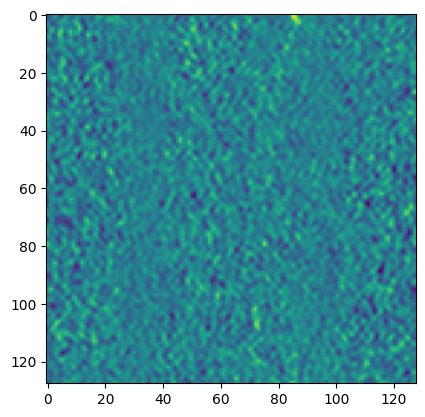

PyObject <matplotlib.image.AxesImage object at 0x7fd717431080>

In [107]:
imshow(Array(@view GPUprob.vars.bx[:,:,1]))

In [112]:
B_L = [];
B_S = [];
for i = 1:length(ME2.data)
    push!(B_L,ME2.data[i][1])
    push!(B_S,ME2.data[i][2])
end    
ME2.data[1]

(1.6492664463361625e6, 7.481582402911605e-8)

In [118]:
B_L

55-element Array{Any,1}:
 1.6492664463361625e6
 1.6615804455464652e6
 1.7417917555478276e6
 1.9409673144265814e6
 2.324624568550004e6
 2.995287132316743e6
 4.1288582270121984e6
 6.064330409469014e6
 9.817653320049578e6
 2.0487232630816866e7
 7.272372385972568e7
 4.079227980563917e8
 2.387667785942221e9
 ⋮
 1.9876406883035977e12
 2.007801628253824e12
 2.0265833194913813e12
 2.0433670853244297e12
 2.0664381726165051e12
 2.0838952209797266e12
 2.1049418704713076e12
 2.100632605000713e12
 4.6167231347293675e-38
 8.0671676371427e116
 8.604484794184388e217
 1.3165820545705664e-65

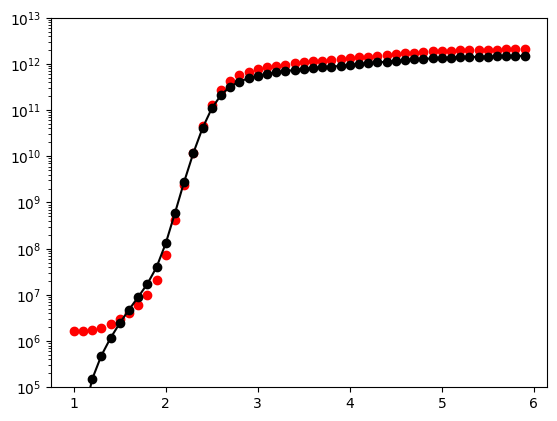

(100000.0, 1.0e13)

In [126]:
plot(ME2.t[1:50],B_L[1:50],"ro")
plot(ME2.t[1:50],B_S[1:50],"ko-")
semilogy()
ylim(1e5,1e13)

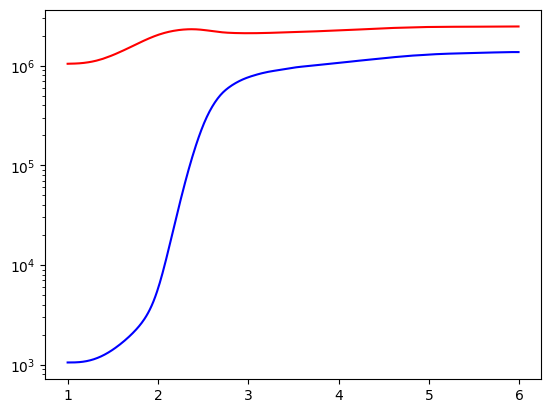

Any[]

In [108]:
plot(KE.t[1:500],KE.data[1:500],"r")
plot(ME.t[1:500],ME.data[1:500],"b")
semilogy()

In [79]:
using LazCh5
uxc = Array(GPUprob.vars.bx);
uyc = Array(GPUprob.vars.by);
uzc = Array(GPUprob.vars.bz);
E = uxc.^2 + uyc.^2 + uzc.^2;
y,x = spectrallines3D(E);

In [91]:
sum(y[1:10]),sum(y[10:end])

(6.67067282453496e12, 4.68286833850926e12)

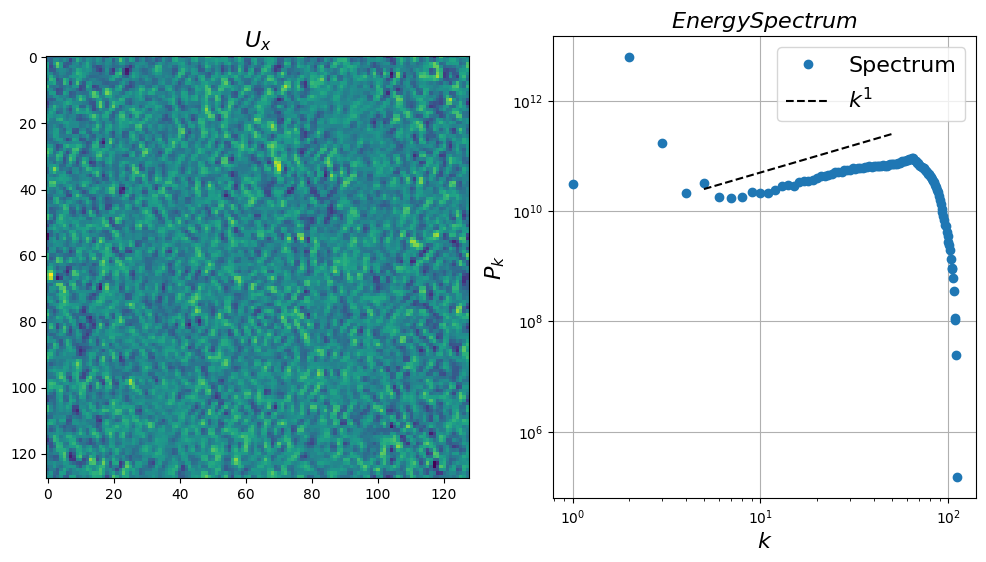

PyObject <matplotlib.legend.Legend object at 0x7fd7176cbc88>

In [87]:
figure(figsize=(12,6))
subplot(121)
imshow(uxc[:,:,5])
title(L"U_x",size=16)
subplot(122)
loglog(x,y,"o",label="Spectrum");
loglog(x[5:50],y[25]*x[5:50].^(1)/10,"k--",label=L"k^{1}")
ylabel(L"P_k}",size=16)
xlabel(L"k",size=16)
title(L"Energy Spectrum",size=16)
grid()
legend(fontsize=16)

In [95]:
CUDA.memory_status()
CUDA.reclaim()
GC.gc(true)
CUDA.memory_status()

Effective GPU memory usage: 52.90% (5.290 GiB/10.000 GiB)
CUDA allocator usage: 4.067 GiB
binned usage: 4.067 GiB (4.067 GiB allocated, 0 bytes cached)
Effective GPU memory usage: 52.90% (5.290 GiB/10.000 GiB)
CUDA allocator usage: 4.067 GiB
binned usage: 4.067 GiB (4.067 GiB allocated, 0 bytes cached)


In [43]:
typeof(CuArray)

UnionAll